In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

##SGD with Heavy ball

In [0]:
import torch
from torch.optim.optimizer import Optimizer, required


class SGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
                  v = \rho * v + g \\
                  p = p - lr * v

        where p, g, v and :math:`\rho` denote the parameters, gradient,
        velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
             v = \rho * v + lr * g \\
             p = p - v

        The Nesterov version is analogously modified.
    """
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, heavy_ball=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        
        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov, 
                        heavy_ball=heavy_ball)
        
        if heavy_ball and (momentum <= 0 or dampening != 0):
            raise ValueError("Heavy-ball momentum requires a momentum and zero dampening")

        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(SGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('heavy_ball', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            heavy_ball = group['heavy_ball']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                        param_state['prev_momentum_buffer'] = torch.zeros(buf.size()).cuda()
                    else:
                        buf = param_state['momentum_buffer']
                        prev_buf = param_state['prev_momentum_buffer']
                        if heavy_ball:
                            temp = buf
                            buf.add_(-prev_buf.cpu()).mul_(momentum).add_(1 - dampening, d_p)
                            param_state['prev_momentum_buffer'] = temp
                        else:
                            buf.mul_(momentum).add_(1 - dampening, d_p)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf

                p.data.add_(-group['lr'], d_p)

        return loss

##AccSGD

In [0]:
from torch.optim.optimizer import Optimizer, required
import copy

class AccSGD(Optimizer):
    r"""Implements the algorithm proposed in https://arxiv.org/pdf/1704.08227.pdf, which is a provably accelerated method 
    for stochastic optimization. This has been employed in https://openreview.net/forum?id=rJTutzbA- for training several 
    deep learning models of practical interest. This code has been implemented by building on the construction of the SGD 
    optimization module found in pytorch codebase.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate (required)
        kappa (float, optional): ratio of long to short step (default: 1000)
        xi (float, optional): statistical advantage parameter (default: 10)
        smallConst (float, optional): any value <=1 (default: 0.7)
    Example:
        >>> from AccSGD import *
        >>> optimizer = AccSGD(model.parameters(), lr=0.1, kappa = 1000.0, xi = 10.0)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()
    """

    def __init__(self, params, lr=0.001, kappa = 1000.0, xi = 10.0, smallConst = 0.7, weight_decay=0):
        defaults = dict(lr=lr, kappa=kappa, xi=xi, smallConst=smallConst,
                        weight_decay=weight_decay)
        super(AccSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AccSGD, self).__setstate__(state)

    def step(self, closure=None):
        """ Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            weight_decay = group['weight_decay']
            large_lr = (group['lr']*group['kappa'])/(group['smallConst'])
            Alpha = 1.0 - ((group['smallConst']*group['smallConst']*group['xi'])/group['kappa'])
            Beta = 1.0 - Alpha
            zeta = group['smallConst']/(group['smallConst']+Beta)
            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    param_state['momentum_buffer'] = copy.deepcopy(p.data)
                buf = param_state['momentum_buffer']
                buf.mul_((1.0/Beta)-1.0)
                buf.add_(-large_lr,d_p)
                buf.add_(p.data)
                buf.mul_(Beta)

                p.data.add_(-group['lr'],d_p)
                p.data.mul_(zeta)
                p.data.add_(1.0-zeta,buf)

        return loss

##Load Dataset

In [0]:
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

batch_size = 256
image_dim = 784 #flattened

# dataset construction
transform = transforms.Compose([
    transforms.ToTensor(), # convert to tensor
    transforms.Lambda(lambda x: x.view(image_dim)) # flatten into vector
    ])

train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=True
    ,download=True
    ,transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size
)

test_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST'
    ,train=False
    ,download=True
    ,transform=transform
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size
)

VAE autoencoder

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm_notebook as tqdm
from itertools import chain

import numpy as np

class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer
    and linear projections to the diag-Gauss parameters
    '''
    # YOUR CODE HERE
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        # YOUR CODE HERE
        self.encoder1 = nn.Linear(input_dim, hidden_dim)
        self.encoder21 = nn.Linear(hidden_dim, output_dim)
        self.encoder22 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # YOUR CODE HERE
        e1 = self.encoder1(x)
        r = F.relu(e1)
        e21 = self.encoder21(r)
        e22 = self.encoder22(r)
        return e21, e22

class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer followed by 
    output layer with a sigmoid to squish values
    '''
    # YOUR CODE HERE
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        # YOUR CODE HERE
        self.decoder1 = nn.Linear(input_dim, hidden_dim)
        self.decoder2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # YOUR CODE HERE
        d1 = self.decoder1(x)
        r = F.relu(d1)
        d2 = self.decoder2(r)
        return torch.sigmoid(d2)

##Train VAE

In [53]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec    
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 30

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)

# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, heavy_ball=True)
# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)
# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, nesterov=True)
optimizer = AccSGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)

lossall_asgd = []
tlossall_asgd = []
# training loop
for epoch in range(nEpoch):
    losses = []
    tlosses = []
    trainloader = tqdm(train_loader)
    testloader = tqdm(test_loader)
    
    dec.train()
    enc.train()
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]
        
        kl = 0 
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
        kl /= 784 * 128
#         kl=KLD
  
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    lossall_asgd.append(sum(losses))
    
    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE
    print("-----Epoch: "+str(epoch)+"-----"+str(sum(losses)))
    

    dec.eval()
    enc.eval()

    for i, data in enumerate(testloader, 0):
      inputs, _ = data

      mu, log_sigma2 = enc(inputs)
      z = sample(mu, log_sigma2)
      outputs = dec(z)
      recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]

      kl = 0 
      # Compute the term kl which is then added to the total loss
      # YOUR CODE HERE
      kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
      kl /= 784 * 128

      loss = recon + kl
      tlosses.append(loss.item())
    tlossall_asgd.append(sum(tlosses))
    print(str(sum(tlosses)))

  
  

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


-----Epoch: 0-----82183.39932250977
11862.66421508789


-----Epoch: 1-----66783.46371459961
11048.775360107422


-----Epoch: 2-----64322.19012451172
11014.158325195312


-----Epoch: 3-----63777.47229003906
10853.555786132812


-----Epoch: 4-----63363.65539550781
10821.847961425781


-----Epoch: 5-----63082.05419921875
10808.621520996094


-----Epoch: 6-----62893.2227935791
10776.323181152344


-----Epoch: 7-----62737.64912414551
10749.061218261719


-----Epoch: 8-----62594.20388793945
10708.60317993164


-----Epoch: 9-----62500.00325012207
10686.789825439453


-----Epoch: 10-----62378.12615966797
10654.293273925781


-----Epoch: 11-----62342.3030090332
10679.785064697266


-----Epoch: 12-----62229.15705871582
10656.429443359375


-----Epoch: 13-----62148.21504211426
10644.266357421875


-----Epoch: 14-----62045.956298828125
10625.602096557617


-----Epoch: 15-----61969.444412231445
10615.625213623047


-----Epoch: 16-----61870.112869262695
10590.097900390625


-----Epoch: 17-----61814.27734375
10595.079177856445


-----Epoch: 18-----61734.07582092285
10565.21369934082


-----Epoch: 19-----61637.881118774414
10533.6318359375


-----Epoch: 20-----61613.83821105957
10656.805389404297


-----Epoch: 21-----61555.517654418945
10536.248977661133


-----Epoch: 22-----61452.2657623291
10479.667861938477


-----Epoch: 23-----61359.78298950195
10502.618438720703


-----Epoch: 24-----61289.97932434082
10504.877395629883


-----Epoch: 25-----61328.36587524414
10539.166580200195


-----Epoch: 26-----61219.73838806152
10485.990234375


-----Epoch: 27-----61160.24937438965
10590.160598754883


-----Epoch: 28-----61130.46064758301
10447.043212890625


-----Epoch: 29-----61037.70365905762
10442.405395507812


In [54]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec    
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 30

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)

# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, heavy_ball=True)
# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)
optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, nesterov=True)
# optimizer = AccSGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)

lossall_nag = []
tlossall_nag = []
# training loop
for epoch in range(nEpoch):
    losses = []
    tlosses = []
    trainloader = tqdm(train_loader)
    testloader = tqdm(test_loader)
    
    dec.train()
    enc.train()
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]
        
        kl = 0 
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
        kl /= 784 * 128
#         kl=KLD
  
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    lossall_nag.append(sum(losses))
    
    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE
    print("-----Epoch: "+str(epoch)+"-----"+str(sum(losses)))
    

    dec.eval()
    enc.eval()

    for i, data in enumerate(testloader, 0):
      inputs, _ = data

      mu, log_sigma2 = enc(inputs)
      z = sample(mu, log_sigma2)
      outputs = dec(z)
      recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]

      kl = 0 
      # Compute the term kl which is then added to the total loss
      # YOUR CODE HERE
      kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
      kl /= 784 * 128

      loss = recon + kl
      tlosses.append(loss.item())
    tlossall_nag.append(sum(tlosses))
    print(str(sum(tlosses)))

  
  

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


-----Epoch: 0-----72448.80865478516
10991.880096435547


-----Epoch: 1-----64075.299560546875
10891.992095947266


-----Epoch: 2-----63299.607177734375
10790.18344116211


-----Epoch: 3-----62769.836349487305
10718.417602539062


-----Epoch: 4-----62383.15832519531
10668.152252197266


-----Epoch: 5-----62118.51026916504
10621.874145507812


-----Epoch: 6-----61916.383712768555
10606.945388793945


-----Epoch: 7-----61769.93437194824
10560.668182373047


-----Epoch: 8-----61609.59678649902
10538.73469543457


-----Epoch: 9-----61478.50459289551
10526.001434326172


-----Epoch: 10-----61361.18240356445
10518.6171875


-----Epoch: 11-----61297.668853759766
10485.520431518555


-----Epoch: 12-----61200.51950073242
10520.29916381836


-----Epoch: 13-----61118.11054992676
10497.03352355957


-----Epoch: 14-----61029.2527923584
10482.950958251953


-----Epoch: 15-----60948.861251831055
10449.392303466797


-----Epoch: 16-----60885.66015625
10467.107055664062


-----Epoch: 17-----60821.640533447266
10425.602767944336


-----Epoch: 18-----60746.93771362305
10487.194030761719


-----Epoch: 19-----60674.00811767578
10513.260375976562


-----Epoch: 20-----60687.01817321777
10496.489974975586


-----Epoch: 21-----60584.77574157715
10421.021697998047


-----Epoch: 22-----60562.62031555176
10385.652969360352


-----Epoch: 23-----60509.53114318848
10402.83610534668


-----Epoch: 24-----60453.9669342041
10465.822616577148


-----Epoch: 25-----60421.62307739258
10413.020599365234


-----Epoch: 26-----60356.76416015625
10507.84765625


-----Epoch: 27-----60367.24366760254
10430.341659545898


-----Epoch: 28-----60290.57385253906
10508.907577514648


-----Epoch: 29-----60285.08006286621
10407.256469726562


In [56]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec    
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 30

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)

# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, heavy_ball=True)
optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)
# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, nesterov=True)
# optimizer = AccSGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)

lossall_sgd = []
tlossall_sgd = []
# training loop
for epoch in range(nEpoch):
    losses = []
    tlosses = []
    trainloader = tqdm(train_loader)
    testloader = tqdm(test_loader)

    dec.train()
    enc.train()
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]
        
        kl = 0 
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
        kl /= 784 * 128
#         kl=KLD
  
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    lossall_sgd.append(sum(losses))
    
    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE
    print("-----Epoch: "+str(epoch)+"-----"+str(sum(losses)))
    

    dec.eval()
    enc.eval()

    for i, data in enumerate(testloader, 0):
      inputs, _ = data

      mu, log_sigma2 = enc(inputs)
      z = sample(mu, log_sigma2)
      outputs = dec(z)
      recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]

      kl = 0 
      # Compute the term kl which is then added to the total loss
      # YOUR CODE HERE
      kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
      kl /= 784 * 128

      loss = recon + kl
      tlosses.append(loss.item())
    tlossall_sgd.append(sum(tlosses))
    print(str(sum(tlosses)))

  
  

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


-----Epoch: 0-----84256.4228515625
12138.609619140625


-----Epoch: 1-----68981.12771606445
11456.049285888672


-----Epoch: 2-----66522.08926391602
11239.669738769531


-----Epoch: 3-----65570.55941772461
11138.90283203125


-----Epoch: 4-----65030.77722167969
11071.677825927734


-----Epoch: 5-----64681.59149169922
11029.173278808594


-----Epoch: 6-----64454.736236572266
11044.963989257812


-----Epoch: 7-----64244.91970825195
10972.730255126953


-----Epoch: 8-----64096.10400390625
10968.728698730469


-----Epoch: 9-----63946.728576660156
10977.069152832031


-----Epoch: 10-----63857.49020385742
10929.201599121094


-----Epoch: 11-----63741.270751953125
10905.866577148438


-----Epoch: 12-----63649.58126831055
10891.236694335938


-----Epoch: 13-----63552.576080322266
10886.570983886719


-----Epoch: 14-----63485.69152832031
10862.557342529297


-----Epoch: 15-----63395.9736328125
10851.031982421875


-----Epoch: 16-----63324.63400268555
10834.550079345703


-----Epoch: 17-----63257.80450439453
10821.003326416016


-----Epoch: 18-----63190.9866027832
10810.223693847656


-----Epoch: 19-----63127.99118041992
10799.93881225586


-----Epoch: 20-----63065.99856567383
10790.509399414062


-----Epoch: 21-----63006.47868347168
10780.049255371094


-----Epoch: 22-----62951.0399017334
10770.504577636719


-----Epoch: 23-----62902.55633544922
10761.54833984375


-----Epoch: 24-----62846.79528808594
10753.053680419922


-----Epoch: 25-----62799.53005981445
10745.362365722656


-----Epoch: 26-----62753.048736572266
10737.182708740234


-----Epoch: 27-----62709.40899658203
10727.888092041016


-----Epoch: 28-----62662.48698425293
10724.665466308594


-----Epoch: 29-----62619.98011779785
10716.046691894531


In [57]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec    
import os

# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1])
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
batch_size = 256
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
nEpoch = 30

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim)

optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, heavy_ball=True)
# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)
# optimizer = SGD(chain(enc.parameters(), dec.parameters()), lr=1e-3, momentum=0.9, nesterov=True)
# optimizer = AccSGD(chain(enc.parameters(), dec.parameters()), lr=1e-3)

lossall_hb = []
tlossall_hb = []
# training loop
for epoch in range(nEpoch):
    losses = []
    tlosses = []
    trainloader = tqdm(train_loader)
    testloader = tqdm(test_loader)
    
    dec.train()
    enc.train()
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data

        optimizer.zero_grad()

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]
        
        kl = 0 
        # Compute the term kl which is then added to the total loss
        # YOUR CODE HERE
        kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
        kl /= 784 * 128
#         kl=KLD
  
        loss = recon + kl
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses.append(loss.item())
        trainloader.set_postfix(loss=np.mean(losses), epoch=epoch)
    lossall_hb.append(sum(losses))
    
    ## Please display some of the generated images in the submitted Notebook
    # YOUR CODE HERE
    print("-----Epoch: "+str(epoch)+"-----"+str(sum(losses)))
    

    dec.eval()
    enc.eval()

    for i, data in enumerate(testloader, 0):
      inputs, _ = data

      mu, log_sigma2 = enc(inputs)
      z = sample(mu, log_sigma2)
      outputs = dec(z)
      recon = F.binary_cross_entropy(outputs, inputs, size_average=False) / inputs.shape[0]

      kl = 0 
      # Compute the term kl which is then added to the total loss
      # YOUR CODE HERE
      kl = - 0.5 * torch.sum(1 + log_sigma2 - mu.pow(2) - log_sigma2.exp())
      kl /= 784 * 128

      loss = recon + kl
      tlosses.append(loss.item())
    tlossall_hb.append(sum(tlosses))
    print(str(sum(tlosses)))

  
  

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


-----Epoch: 0-----86497.07995605469
12343.496185302734


-----Epoch: 1-----69816.93811035156
11508.044158935547


-----Epoch: 2-----66771.32815551758
11258.767883300781


-----Epoch: 3-----65657.00314331055
11151.125305175781


-----Epoch: 4-----65097.7233581543
11089.767822265625


-----Epoch: 5-----64724.765625
11027.161987304688


-----Epoch: 6-----64447.570709228516
10992.332061767578


-----Epoch: 7-----64250.09786987305
11006.371856689453


-----Epoch: 8-----64090.54379272461
10951.540740966797


-----Epoch: 9-----63944.996185302734
10927.613220214844


-----Epoch: 10-----63842.54998779297
10920.575653076172


-----Epoch: 11-----63727.39724731445
10898.13882446289


-----Epoch: 12-----63656.43780517578
10887.58804321289


-----Epoch: 13-----63560.16915893555
10874.002960205078


-----Epoch: 14-----63476.58654785156
10859.569793701172


-----Epoch: 15-----63407.98385620117
10845.927337646484


-----Epoch: 16-----63340.681243896484
10834.339324951172


-----Epoch: 17-----63277.69821166992
10821.218963623047


-----Epoch: 18-----63208.28723144531
10809.56802368164


-----Epoch: 19-----63148.62593078613
10800.88980102539


-----Epoch: 20-----63088.49482727051
10791.94448852539


-----Epoch: 21-----63031.13655090332
10782.470581054688


-----Epoch: 22-----62974.057189941406
10772.068756103516


-----Epoch: 23-----62923.375732421875
10764.62759399414


-----Epoch: 24-----62875.59115600586
10755.749389648438


-----Epoch: 25-----62818.65156555176
10747.498138427734


-----Epoch: 26-----62778.8581237793
10739.446990966797


-----Epoch: 27-----62733.086990356445
10731.751037597656


-----Epoch: 28-----62687.145599365234
10727.152801513672


-----Epoch: 29-----62648.91516113281
10721.405853271484


In [0]:
# lossall_sgd=[86983.71090698242, 74224.66662597656, 70936.25769042969, 68988.49285888672, 67947.98809814453, 67230.36361694336, 66686.66479492188, 66245.2532043457, 65901.27795410156, 65608.97854614258, 65328.04962158203, 65154.16583251953, 64932.540100097656, 64766.89352416992, 64609.14794921875, 64475.98049926758, 64338.518981933594, 64204.61642456055, 64086.2380065918, 63978.96585083008, 63848.62545776367, 63782.92333984375, 63692.573822021484, 63604.44519042969, 63525.210998535156, 63445.39367675781, 63369.306884765625, 63298.50387573242, 63225.8173828125, 63172.19648742676]
# lossall_nag=[71416.80194091797, 63667.4196472168, 62880.87951660156, 62427.406829833984, 62035.85711669922, 61856.64431762695, 61573.05090332031, 61382.28779602051, 61287.34225463867, 61079.45683288574, 61042.15411376953, 60895.89854431152, 60822.65692138672, 60749.54084777832, 60668.3768157959, 60610.56381225586, 60569.784103393555, 60489.922760009766, 60468.41192626953, 60426.29872131348, 60330.80383300781, 60334.5964050293, 60270.89822387695, 60254.09864807129, 60198.10754394531, 60177.6082611084, 60125.65238952637, 60112.395278930664, 60095.03872680664, 60024.00477600098]

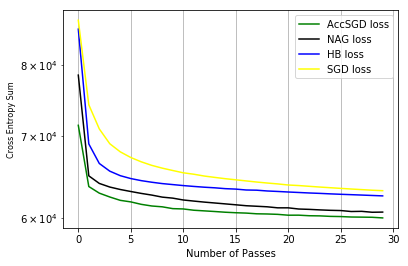

In [46]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
 

x_axix=range(epoch+1)

y_axix2=lossall_asgd
y_axix3=lossall_nag
y_axix4=lossall_hb
y_axix5=lossall_sgd

sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.plot(x_axix, y_axix2, color='green', label='AccSGD loss')
plt.plot(x_axix, y_axix3, color='black', label='NAG loss')
plt.plot(x_axix, y_axix4, color='blue', label='HB loss')
plt.plot(x_axix, y_axix5, color='yellow', label='SGD loss')
plt.legend() 
 
plt.xlabel('Number of Passes')
plt.ylabel('Cross Entropy Sum',fontsize=8)
plt.grid(axis='both')
plt.yscale('log')
plt.savefig("encoder_train.pdf")
plt.show()

In [0]:
from google.colab import files

files.download('encoder_train.pdf')

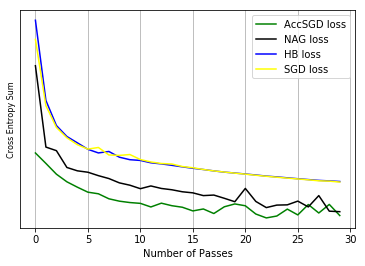

In [58]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
 

x_axix=range(epoch+1)

y_axix2=tlossall_asgd
y_axix3=tlossall_nag
y_axix4=tlossall_hb
y_axix5=tlossall_sgd
 
sub_axix = filter(lambda x:x%200 == 0, x_axix)

plt.plot(x_axix, y_axix3, color='green', label='AccSGD loss')
plt.plot(x_axix, y_axix2, color='black', label='NAG loss')
plt.plot(x_axix, y_axix4, color='blue', label='HB loss')
plt.plot(x_axix, y_axix5, color='yellow', label='SGD loss')

plt.legend()
 
plt.xlabel('Number of Passes')
plt.ylabel('Cross Entropy Sum',fontsize=8)
plt.grid(axis='both')

plt.yscale('log')

plt.savefig("encoder_test.pdf")
plt.show()

In [0]:
from google.colab import files

files.download('encoder_test.pdf')